In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
root_path = "D:/DATAS/Medical/COUGHVID-public_dataset_v3/coughvid_20211012/"

In [ ]:
speech_path = "df1ace30-8912-4844-946b-0180ff898246.wav"  # 只包含语音
strong_cough_path = "c4ccc5d7-bfe0-4b50-a23d-d39918a5f2d5.webm"  # 清晰的咳嗽音
cough_with_noise_path = "006d8d1c-2bf6-46a6-8ef2-1823898a4733.webm"
cough_with_strong_bg_path = "01208e5c-5338-4f1b-b8c6-41c049e40d90.webm"

import IPython.display as ipd
ipd.Audio(root_path+cough_with_noise_path)

In [ ]:
class AudioSegment(object):
    """Monaural audio segment abstraction.

    :param samples: Audio samples [num_samples x num_channels].
    :type samples: ndarray.float32
    :param sample_rate: Audio sample rate.
    :type sample_rate: int
    :raises TypeError: If the sample data type is not float or int.
    """

    def __init__(self, samples, sample_rate):
        """Create audio segment from samples.

        Samples are convert float32 internally, with int scaled to [-1, 1].
        """
        self._samples = self._convert_samples_to_float32(samples)
        self._sample_rate = sample_rate
        if self._samples.ndim >= 2:
            self._samples = np.mean(self._samples, 1)
            
    @property
    def sample_rate(self):
        """返回音频采样率

        :return: Audio sample rate.
        :rtype: int
        """
        return self._sample_rate

    @property
    def num_samples(self):
        """返回样品数量

        :return: Number of samples.
        :rtype: int
        """
        return self._samples.shape[0]

    @property
    def duration(self):
        """返回音频持续时间

        :return: Audio duration in seconds.
        :rtype: float
        """
        return self._samples.shape[0] / float(self._sample_rate)

    @property
    def rms_db(self):
        """返回以分贝为单位的音频均方根能量

        :return: Root mean square energy in decibels.
        :rtype: float
        """
        # square root => multiply by 10 instead of 20 for dBs
        mean_square = np.mean(self._samples ** 2)
        return 10 * np.log10(mean_square)
    
    def __str__(self):
        """返回该音频的信息"""
        return ("%s: num_samples=%d, sample_rate=%d, duration=%.2fsec, "
                "rms=%.2fdB" % (type(self), self.num_samples, self.sample_rate, self.duration, self.rms_db))
    
    def _convert_samples_to_float32(self, samples):
        """Convert sample type to float32.

        Audio sample type is usually integer or float-point.
        Integers will be scaled to [-1, 1] in float32.
        """
        float32_samples = samples.astype('float32')
        if samples.dtype in np.sctypes['int']:
            bits = np.iinfo(samples.dtype).bits
            float32_samples *= (1. / 2 ** (bits - 1))
        elif samples.dtype in np.sctypes['float']:
            pass
        else:
            raise TypeError("Unsupported sample type: %s." % samples.dtype)
        return float32_samples

In [11]:
def vad(wav, top_db=20, overlap=200):
    # Split an audio signal into non-silent intervals
    intervals = librosa.effects.split(wav, top_db=top_db)
    if len(intervals) == 0:
        return wav
    wav_output = [np.array([])]
    for sliced in intervals:
        seg = wav[sliced[0]:sliced[1]]
        if len(seg) < 2 * overlap:
            wav_output[-1] = np.concatenate((wav_output[-1], seg))
        else:
            wav_output.append(seg)
    wav_output = [x for x in wav_output if len(x) > 0]

    if len(wav_output) == 1:
        wav_output = wav_output[0]
    else:
        wav_output = concatenate(wav_output)
    return wav_output

def concatenate(wave, overlap=200):
    total_len = sum([len(x) for x in wave])
    unfolded = np.zeros(total_len)

    # Equal power crossfade
    window = np.hanning(2 * overlap)
    fade_in = window[:overlap]
    fade_out = window[-overlap:]

    end = total_len
    for i in range(1, len(wave)):
        prev = wave[i - 1]
        curr = wave[i]

        if i == 1:
            end = len(prev)
            unfolded[:end] += prev

        max_idx = 0
        max_corr = 0
        pattern = prev[-overlap:]
        # slide the curr batch to match with the pattern of previous one
        for j in range(overlap):
            match = curr[j:j + overlap]
            corr = np.sum(pattern * match) / [(np.sqrt(np.sum(pattern ** 2)) * np.sqrt(np.sum(match ** 2))) + 1e-8]
            if corr > max_corr:
                max_idx = j
                max_corr = corr

        # Apply the gain to the overlap samples
        start = end - overlap
        unfolded[start:end] *= fade_out
        end = start + (len(curr) - max_idx)
        curr[max_idx:max_idx + overlap] *= fade_in
        unfolded[start:end] += curr[max_idx:]
    return unfolded[:end]

In [3]:
test_y, sr = librosa.core.load(sample_path, sr=16000)
test_segment = AudioSegment(samples=test_y, sample_rate=sr)
print(test_segment)
test_segment

C:\Users\zhaoke\.conda\envs\torchbert\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


<class '__main__.AudioSegment'>: num_samples=157440, sample_rate=16000, duration=9.84sec, rms=-22.78dB


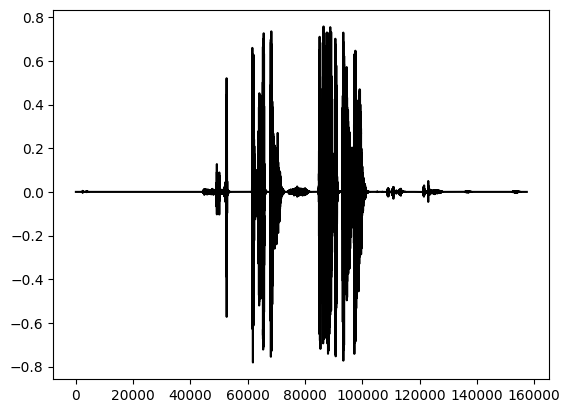

In [5]:
plt.figure(0)
plt.plot(range(len(test_y)), test_y, color='black')
plt.show()

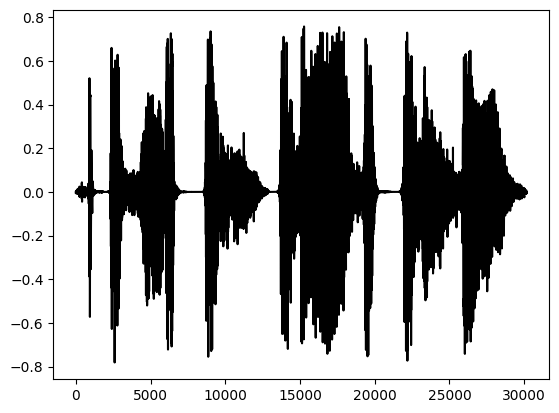

In [12]:
vaded_sample = vad(test_segment._samples)
plt.figure(1)
plt.plot(range(len(vaded_sample)), vaded_sample, color='black')
plt.show()